In [2]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from scipy.ndimage import filters
import imtools
%matplotlib inline

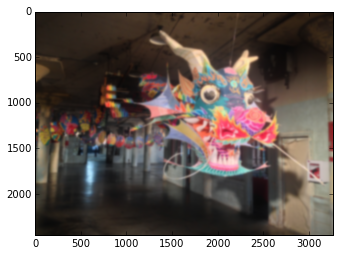

In [9]:
# Gaussian Blur Example
NUM_CHANNELS = 3

img_path = 'images/at_large.jpg'
img = Image.open(img_path)

image_array = np.array(img)
filtered_image_array = np.zeros(image_array.shape)
theta = 10
for i in range(NUM_CHANNELS):
    filtered_image_array[:,:,i] = filters.gaussian_filter(image_array[:,:,i], theta)

filtered_image_array = np.uint8(filtered_image_array)    
    
plt.imshow(filtered_image_array)
plt.show()